# Notebook d'analyse des modèles

In [1]:
import pandas as pd 
import tensorflow as tf 
import numpy as np

import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))


from inference.inference_typologie import TypologieModel
from inference.encodeur import EncodeurModel

import yaml
with open(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(''))), 'config.yaml'), 'r') as stream:
    config_data = yaml.load(stream, Loader=yaml.FullLoader)

MODEL_PATH = config_data['inference']['loading_path']['model_path']
PREPRO_PATH = config_data['Data']['prepro']['path']

model = TypologieModel()
model.typo = 'tef'
model.load(MODEL_PATH)

classification_encoder = EncodeurModel()
classification_encoder.load(MODEL_PATH)

DATA_PATH = config_data['training']['data']['mrv']['file_path']
df = pd.read_csv(DATA_PATH)
X = df[['FABRICANT', 'CLASSIFICATION', 'DESCRIPTION_INCIDENT',
                     'ETAT_PATIENT', 'ACTION_PATIENT']].fillna('NON RENSEIGNE')


import joblib
le_effet = joblib.load(os.path.abspath(MODEL_PATH+'/TEF_ID_Encoder.sav'))
df_effets = pd.read_csv(PREPRO_PATH+"/referentiel_dispositif_effets_connus.csv", delimiter=';', encoding='ISO-8859-1')

## Prediction avec le modèle courrant

In [ ]:
X['CLASSIFICATION'] = classification_encoder.transform(X['CLASSIFICATION'])
X = model.transform(X)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
pred = model.predict(X)

In [32]:
pred.shape

(76954, 273)

## Fonction pour la comprension Humaine

In [2]:

def get_name_effet(x: str) -> (str):
    """
    Renvoie le nom de la classe d'effet à partir  du numéro précisé dans le référentiel. 
    Si le numéro n'existe pas, alors il ne renvoie un string vide.. 

    Args:
        x (str): Numéro de classe du TYPE_EFFET

    Returns:
        effet (str): Nom de la classe du TYPE_EFFET
    """
    try:
        effet = df_effets[df_effets['TEF_ID']
                          == int(x[1:])]['TYPE_EFFET'].iloc[0]
        return (effet)
    except:
        return("")

def multi_format(n: int, le):
    """
    Transforme le numéro d'une classe n en un vecteur de taille du nombre de classes avec un un en n ième position

    Args:
        n (int): Le numéro de classe
        le (sk.preprocessing.labelEncoder): le label encodeur fitté sur la variable visée

    Returns:
        y (np.array): vecteur avec un 1 en n ième position
    """
    dim = len(le.classes_)
    y = np.zeros(dim, dtype=int)
    y[n] = 1
    return y


def create_chart_data_typo(pred: np.array, name, le) -> (pd.DataFrame):
    """
    Reçoit en entrée le vecteur de prédiction de probabilités du modèle pour la TYPOLOGIE et
    renvoie une Dataframe avec le nom des classes associés à chaque proba.
    Permet de créer un affichage lisible facilement dans l'appli web.  


    Args:
        pred (np.array): Vecteur des probabilité sortie par le modèle d'inférence de classification. 
        name (function, optional): fonction associé à la variable à  inférer. Defaults to get_name.
            - get_name_effet: TYPE_EFFET
            - get_name_consequence: CONSEQUENCE_DYSFONCTIONNEMENT
            - get_name_dysfonctionnement: TYPE_DYSFONCTIONNEMENT
        le (sk.preprocessing.labelEncoder, optional): [description]. Defaults to le.

    Returns: 
        df_r (pd.DataFrame): DataFrame contenant les probabilités et le nom des classes associées triées par ordre décroissant.
    """
    df_r = pd.DataFrame(pred[0])
    df_r["multi"] = df_r.index.map(lambda x: multi_format(x, le))
    df_r['class'] = df_r.multi.map(
        lambda x: le.inverse_transform(np.array([x]))[0][0])
    df_r['class_name'] = df_r['class'].apply(lambda x: name(x))
    df_r['proba'] = df_r[0]
    df_r = df_r.drop(0, axis=1)
    df_r = df_r.sort_values('proba', ascending=False)
    return(df_r)

def name(y):
    r = create_chart_data_typo([y], get_name_effet, le=le_effet)
    return r['class'].iloc[0]

In [6]:
NAME = []
for i in range(len(pred)):
    NAME.append(name(pred[i]))

k['name'] = NAME

In [105]:
k.groupby('name').count().sort_values('y',ascending=False)

y    38671
Name: E1213, dtype: int64

In [109]:
df.groupby(['TEF_ID']).count().sort_values('DESCRIPTION_INCIDENT',ascending=False)

,Unnamed: 0,NUMERO_DECLARATION,TYPE_DECLARATION,TYPE_DECLARANT,NB_PATIENT_CONCERNE,NB_DISPOSITIF_CONCERNE,DESCRIPTION_INCIDENT,ETAT_PATIENT,ACTION_PATIENT,DCO_ID,...,DISTRIBUTEUR,TDY_ID,TYPE_DYSFONCTIONNEMENT,CDY_ID,CONSEQUENCE_DYSFONCTIONNEMENT,TYPE_EFFET,GRAVITE,NUMERO,TYPE_VIGILANCE,CLASSIFICATION
TEF_ID,,,,,,,,,,,,,,,,,,,,,
E1213,9774,9774,9774,9774,5593,5848,9773,9695,9265,9771,...,4856,9656,9656,1633,1633,9774,9663,9774,9774,9758
E1323,3342,3342,3342,3342,2323,1527,3342,3130,2456,3342,...,3263,181,181,2122,2122,3342,3342,3342,3342,3322
E1483,2751,2751,2751,2751,1639,1555,2751,2744,2583,2751,...,1486,2434,2434,1042,1042,2751,2727,2751,2751,2740
E1239,2253,2253,2253,2253,1232,1292,2253,2249,2118,2253,...,1079,2196,2196,740,740,2253,2225,2253,2253,2252
E1445,2168,2168,2168,2168,1377,861,2168,1983,1448,2168,...,2133,107,107,1374,1374,2168,2168,2168,2168,2153
E1451,1933,1933,1933,1933,1255,777,1933,1766,1296,1933,...,1874,106,106,1208,1208,1933,1933,1933,1933,1921
E1444,1764,1764,1764,1764,1169,747,1764,1633,1327,1764,...,1678,246,246,1093,1093,1764,1763,1764,1764,1745
E1405,1757,1757,1757,1757,1287,1287,1757,1739,1568,1757,...,938,1606,1606,398,398,1757,1754,1757,1757,1744
E1242,1756,1756,1756,1756,1050,787,1756,1679,1329,1756,...,1509,566,566,907,907,1756,1751,1756,1756,1747


## Commentaire :
Notre modèl actuelle prédit la classe E1213 de manière trop importante..
 
# Creation de nouveau modèle

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV

#from clean_text import STOP_WORDS

import joblib
import keras

from sklearn.decomposition import TruncatedSVD


def create_multilabel_data(df: pd.DataFrame):
    """Fonction qui prépare le jeu de données multilabel pour l'entrainement des modèles de Typologie. Cette fonction ne renvoie rien. 
    Elle créer un fichier pkl avec les données et elle permet de : 
        - créer un dossier model sous la racine
        - gérer les NaN pour les colonnes
        - Remplir avec le code correspondant les codes de la typologie
        - Encoder la classification de l'incident et de sauvegarder l'encodeur  dans le dossier model
        - regrouper les déclaration par texte identique pour créer les données multilabel
        - Sauvegarder la base de donnée nettoyée: multilabel_data.pkl

    Args:
        df (pd.DataFrame): Base de donnée MRveil

    Returns:
        None
    """

    #logger.info("    Gestion des NaN")
    # 1) On gère nan pour les colonnes contenant du text
    text_columns = ["DESCRIPTION_INCIDENT", "ETAT_PATIENT",
                    "FABRICANT", 'ACTION_PATIENT', 'LIBELLE_COMMERCIAL']
    df[text_columns] = df[text_columns].fillna('NON RENSEIGNE')

    #df  = df[df['TEF_ID'].notna()]

    # 2) on gère les NaN pour chaque Colonnes
    df['NUMERO_DECLARATION'] = df['NUMERO_DECLARATION'].fillna('NON RENSEIGNE')
    df['DESCRIPTION_INCIDENT'] = df['DESCRIPTION_INCIDENT'].fillna(
        'NON RENSEIGNE')
    df['ETAT_PATIENT'] = df['ETAT_PATIENT'].fillna('NON RENSEIGNE')
    df['CLASSIFICATION'] = df['CLASSIFICATION'].fillna('NON RENSEIGNE')
    df['FABRICANT'] = df['FABRICANT'].fillna('NON RENSEIGNE')
    df['LIBELLE_COMMERCIAL'] = df['LIBELLE_COMMERCIAL'].fillna('NON RENSEIGNE')
    df['REFERENCE_COMMERCIALE'] = df['REFERENCE_COMMERCIALE'].fillna(
        'NON RENSEIGNE')

    df['text'] = df['DESCRIPTION_INCIDENT']+'. '+df['ETAT_PATIENT']

    # Effet
    df['TEF_ID'] = df['TEF_ID'].fillna('E1213')
    # DYSFONCTIONNEMENT
    df['TDY_ID'] = df['TDY_ID'].fillna("D0")
    # CONSÉQUENCES
    df['CDY_ID'] = df['CDY_ID'].fillna("C0")

    #logger.info('    Done ! ')

    le = LabelEncoder()
    df["CLASSIFICATION"] = le.fit_transform(df["CLASSIFICATION"])
    #joblib.dump(le, './models/'+'classification'+'_Encoder.sav')

    #logger.info('    Création du jeu de données Multilabel et sauvegarde')
    # La typologie est en générale multilabel
    df_id = df.groupby('text').agg({'TEF_ID': lambda x: list(set(x)),
                                    'CDY_ID': lambda x: list(set(x)),
                                    'TDY_ID': lambda x: list(set(x))
                                    })

    # On fusionne les multilabels et on supprime les doublons
    df = df.drop(['TEF_ID', 'CDY_ID', 'TDY_ID'], axis=1)
    df = pd.merge(df, df_id, on='text')
    df = df.drop_duplicates('text')
    df = df.reset_index(drop=True)

    # On remplace les strings vide
    df.replace('', 'NON RENSEIGNE', inplace=True)
    # Sauvegarde des données nettoyées
    df.to_pickle('./multilabel_data.pkl')
    #logger.info('    Done ! Sauvegardés dans multilabel.pkl')

    return (df)

In [4]:
multi_df =  create_multilabel_data(df)
print(len(multi_df))

32904


In [5]:
typo = 'TEF_ID'

from training import model_typologie

X_train_, y_train,X_test, y_test = model_typologie.prepare_data(multi_df, typo, n=1000, split=True)



Epoch 1/5
659/659 [==============================] - 28s 42ms/step - loss: 0.0198 - categorical_accuracy: 0.5727 - val_loss: 0.0133 - val_categorical_accuracy: 0.6118
Epoch 2/5
659/659 [==============================] - 29s 44ms/step - loss: 0.0148 - categorical_accuracy: 0.6264 - val_loss: 0.0123 - val_categorical_accuracy: 0.6374
Epoch 3/5
659/659 [==============================] - 32s 49ms/step - loss: 0.0136 - categorical_accuracy: 0.6497 - val_loss: 0.0118 - val_categorical_accuracy: 0.6437
Epoch 4/5
659/659 [==============================] - 29s 44ms/step - loss: 0.0128 - categorical_accuracy: 0.6596 - val_loss: 0.0117 - val_categorical_accuracy: 0.6425
Epoch 5/5
659/659 [==============================] - 29s 44ms/step - loss: 0.0122 - categorical_accuracy: 0.6674 - val_loss: 0.0116 - val_categorical_accuracy: 0.6431
0.6694351523215256
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00    

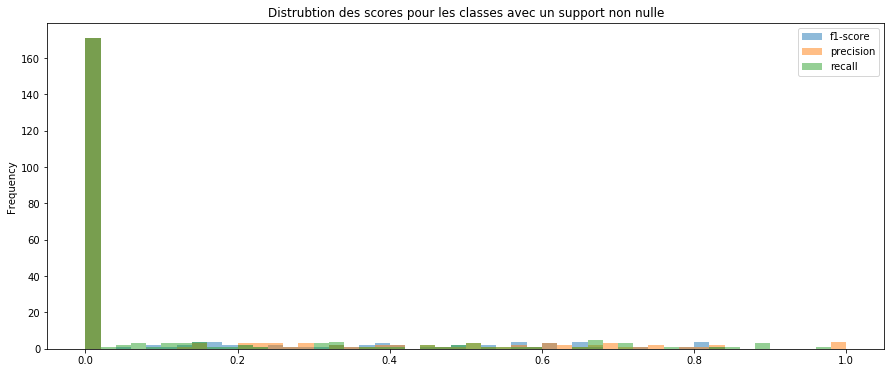

<Figure size 432x288 with 0 Axes>

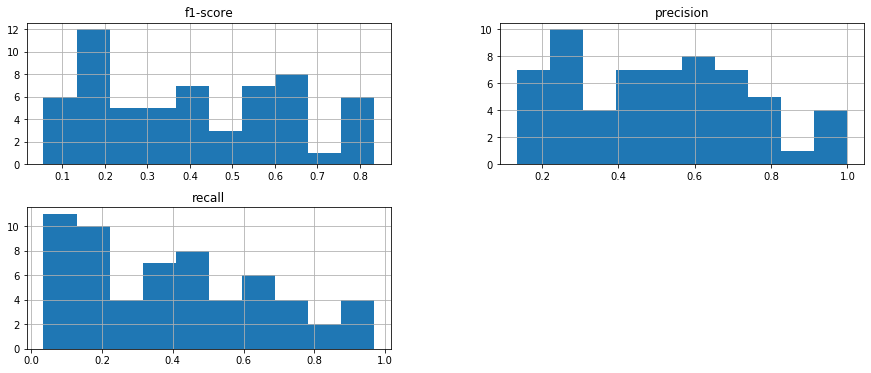

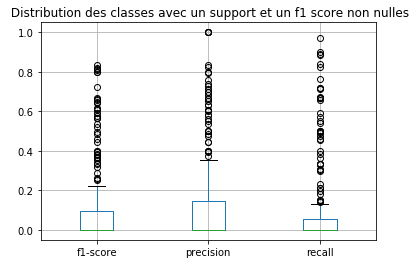

In [45]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score, f1_score, classification_report

model_multi = model_typologie.train(X_train_, y_train, typo=typo)
model_typologie.evaluate_model(model_multi, X_test, y_test, typo)
y_pred = model_multi.predict(X_test)
val=0.12
pred =y_pred.copy()

pred[pred >= val] = 1
pred[pred < val] = 0

precision = precision_score(y_test, pred, average='samples')
recall = recall_score(y_test, pred, average='samples')
f1 = f1_score(y_test, pred, average='samples')
print(f1)
print(classification_report(y_test,pred))
make_repport(classification_report(y_test,pred,output_dict=True))

## Cosntruction des poids

In [7]:
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.utils import class_weight
tf.random.set_seed(1234)
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

from scipy import stats

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Bidirectional, SimpleRNN, Input, concatenate, Reshape

def compute_weight(mlb,y,f):
    w = class_weight.compute_class_weight('balanced',np.unique(y),y)
    u = f(w)# np.exp(w.dot(1000)) / np.sum(np.exp(w.dot(1000)))
    class_weights = dict(zip(np.arange(0,len(mlb.classes_)),u))
    print('##### Distribution')
    print(stats.describe(u))

    return(class_weights)

def train_typo(W):
    model_w = Sequential()
    model_w.add(Bidirectional(LSTM(200, dropout=0.2,return_sequences=False)))
    model_w.add(Dense(y_train.shape[1], activation='softmax', dtype='float64'))
    model_w.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=['categorical_accuracy'])

    epochs = 5
    batch_size = 32

    history = model_w.fit(X_train_, y_train, epochs=epochs,class_weight=W,
                        batch_size=batch_size, validation_split=0.2)

    print("F1 sample : ", model_typologie.evaluate_model(model_w, X_test, y_test, typo))

    return model_w

def evaluate_model (model_w, X_test,y_test, val):
    y_pred = model_w.predict(X_test)
    val=0.1
    pred =y_pred.copy()

    pred[pred >= val] = 1
    pred[pred < val] = 0

    precision = precision_score(y_test, pred, average='samples')
    recall = recall_score(y_test, pred, average='samples')
    f1 = f1_score(y_test, pred, average='samples')
    print("seui", val)
    print("    Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print(classification_report(y_test, pred))
    return(classification_report(y_test, pred,output_dict=True))



In [39]:
mlb = MultiLabelBinarizer()
h = mlb.fit_transform(multi_df[typo])
y = df[typo].values
#f = lambda x : x**(1/1.5)
f = lambda x: x
val = 0.1
W = compute_weight(mlb,y,f)
model_w = train_typo(W) 
rapport =  evaluate_model (model_w,X_test,y_test, val)

##### Distribution
DescribeResult(nobs=273, minmax=(0.009356483681839676, 281.8827838827839), mean=39.13052389732567, variance=4690.131730311423, skewness=2.5717374094407517, kurtosis=6.048880550883222)
Epoch 1/5
659/659 [==============================] - 28s 42ms/step - loss: 0.0300 - categorical_accuracy: 0.0665 - val_loss: 0.0244 - val_categorical_accuracy: 0.0792
Epoch 2/5
659/659 [==============================] - 29s 45ms/step - loss: 0.0248 - categorical_accuracy: 0.1034 - val_loss: 0.0228 - val_categorical_accuracy: 0.1195
Epoch 3/5
659/659 [==============================] - 29s 45ms/step - loss: 0.0194 - categorical_accuracy: 0.1302 - val_loss: 0.0219 - val_categorical_accuracy: 0.1390
Epoch 4/5
659/659 [==============================] - 33s 50ms/step - loss: 0.0153 - categorical_accuracy: 0.1676 - val_loss: 0.0209 - val_categorical_accuracy: 0.1626
Epoch 5/5
659/659 [==============================] - 29s 45ms/step - loss: 0.0131 - categorical_accuracy: 0.1841 - val_loss: 0.02

Il y a  0.15073529411764705 % de classe avec un support de Zero
Il y a  0.8492647058823529 % de classe avec un support différent de 0
Il y a 0.6233766233766234 % de classe avec un F1 score de 0 et un support différent de 0


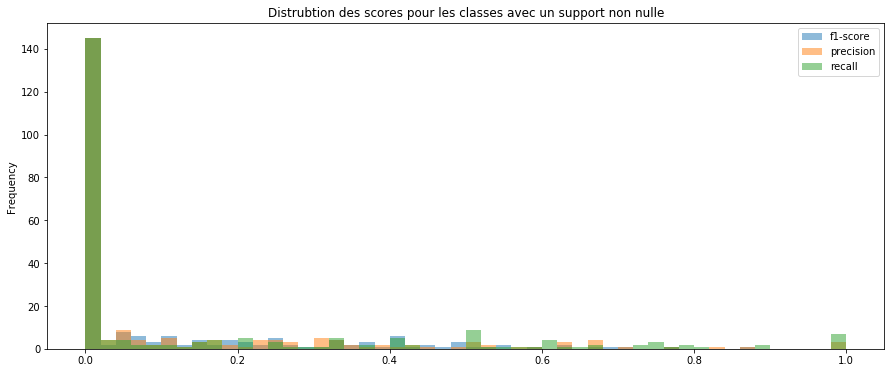

<Figure size 432x288 with 0 Axes>

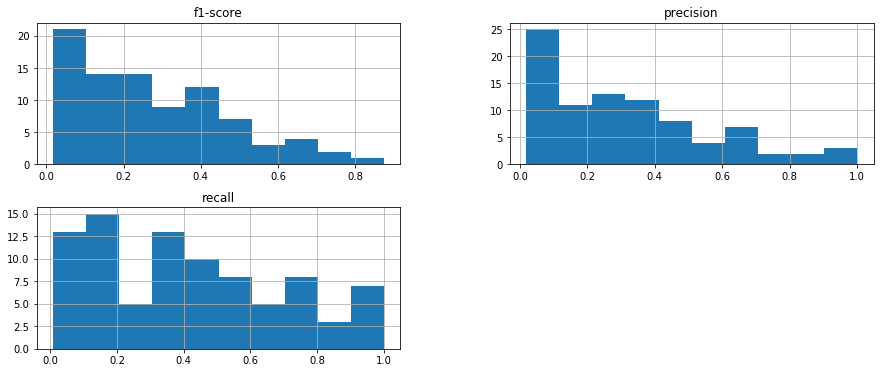

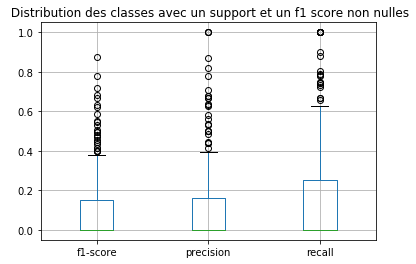

In [40]:
import matplotlib.pyplot as plt 

def make_repport(rapport):
    df_R = pd.DataFrame(rapport).T
    df_r = df_R.iloc[:272]
    print('Il y a ',len(df_r[df_r['support']==0])/len(df_r),'% de classe avec un support de Zero')
    non_zero = df_r[df_r['support']!=0]
    print('Il y a ',len(non_zero)/len(df_r),'% de classe avec un support différent de 0')

    print('Il y a', len(non_zero[non_zero['f1-score']==0])/len(non_zero),'% de classe avec un F1 score de 0 et un support différent de 0')
    
    non_zero[['f1-score','precision','recall']].plot(kind='hist',bins=50, alpha=0.5, title = "Distrubtion des scores pour les classes avec un support non nulle",figsize=(15,6))
    plt.show()

    plt.figure()
    non_zero[non_zero['f1-score']!=0][['f1-score','precision','recall']].hist(figsize=(15,6))
    plt.title(" Distribution des classes avec un support et un f1 score non nulles")
    plt.show()

    plt.figure()
    non_zero[['f1-score','precision','recall']].boxplot(figsize=(15,6))
    plt.title(" Distribution des classes avec un support et un f1 score non nulles")
    plt.show()



make_repport(rapport)


##### Distribution
DescribeResult(nobs=273, minmax=(0.044402604290964605, 42.991147240002995), mean=8.955440138598801, variance=116.46035485729533, skewness=1.8949652127702776, kurtosis=3.058233605004016)
Epoch 1/5
659/659 [==============================] - 32s 49ms/step - loss: 0.0169 - categorical_accuracy: 0.3003 - val_loss: 0.0191 - val_categorical_accuracy: 0.5130
Epoch 2/5
659/659 [==============================] - 31s 47ms/step - loss: 0.0136 - categorical_accuracy: 0.5269 - val_loss: 0.0170 - val_categorical_accuracy: 0.5896
Epoch 3/5
659/659 [==============================] - 30s 45ms/step - loss: 0.0113 - categorical_accuracy: 0.5480 - val_loss: 0.0160 - val_categorical_accuracy: 0.5421
Epoch 4/5
659/659 [==============================] - 30s 46ms/step - loss: 0.0095 - categorical_accuracy: 0.5350 - val_loss: 0.0151 - val_categorical_accuracy: 0.5060
Epoch 5/5
659/659 [==============================] - 30s 46ms/step - loss: 0.0083 - categorical_accuracy: 0.5268 - val_loss: 0.

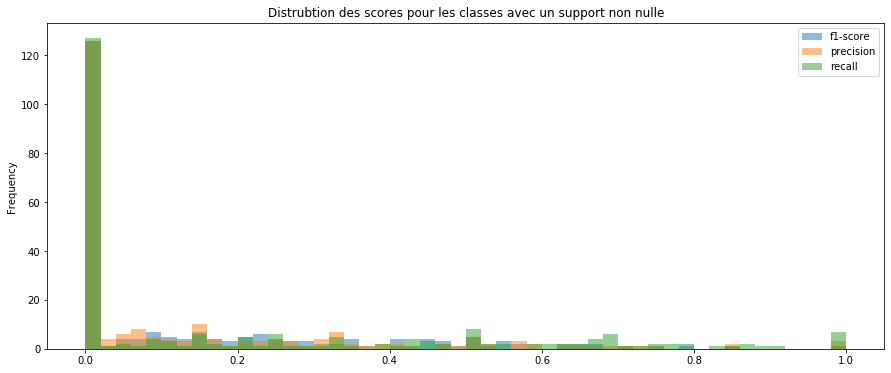

<Figure size 432x288 with 0 Axes>

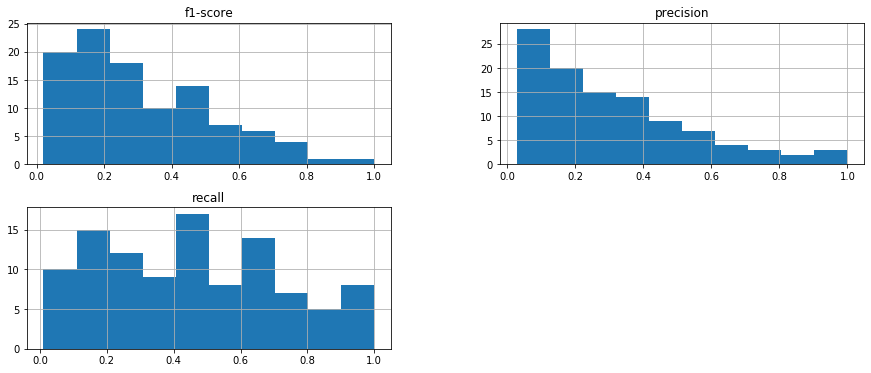

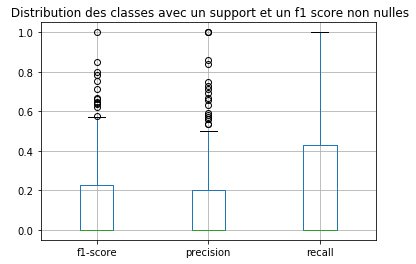

In [41]:
mlb = MultiLabelBinarizer()
h = mlb.fit_transform(multi_df[typo])
y = df[typo].values
f = lambda x : x**(1/1.5)
#f = lambda x: x
val = 0.1
W = compute_weight(mlb,y,f)
model_w = train_typo(W) 
rapport =  evaluate_model (model_w,X_test,y_test, val)
make_repport(rapport)


##### Distribution
DescribeResult(nobs=273, minmax=(5.7038136624487965, 6.36626902518402), mean=5.8106741310004, variance=0.027830428565363316, skewness=2.220855829553786, kurtosis=4.3122989396492155)
Epoch 1/5
659/659 [==============================] - 33s 50ms/step - loss: 0.1104 - categorical_accuracy: 0.5738 - val_loss: 0.0132 - val_categorical_accuracy: 0.6190
Epoch 2/5
659/659 [==============================] - 33s 50ms/step - loss: 0.0827 - categorical_accuracy: 0.6325 - val_loss: 0.0122 - val_categorical_accuracy: 0.6435
Epoch 3/5
659/659 [==============================] - 32s 49ms/step - loss: 0.0760 - categorical_accuracy: 0.6531 - val_loss: 0.0119 - val_categorical_accuracy: 0.6431
Epoch 4/5
659/659 [==============================] - 33s 50ms/step - loss: 0.0720 - categorical_accuracy: 0.6640 - val_loss: 0.0118 - val_categorical_accuracy: 0.6384
Epoch 5/5
659/659 [==============================] - 28s 43ms/step - loss: 0.0688 - categorical_accuracy: 0.6722 - val_loss: 0.0116

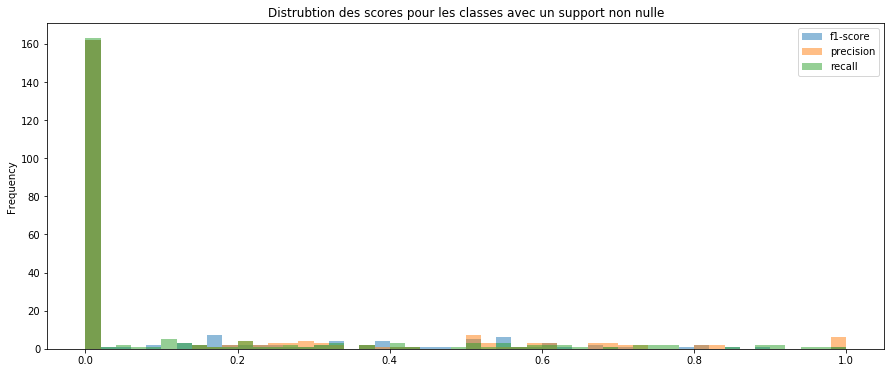

<Figure size 432x288 with 0 Axes>

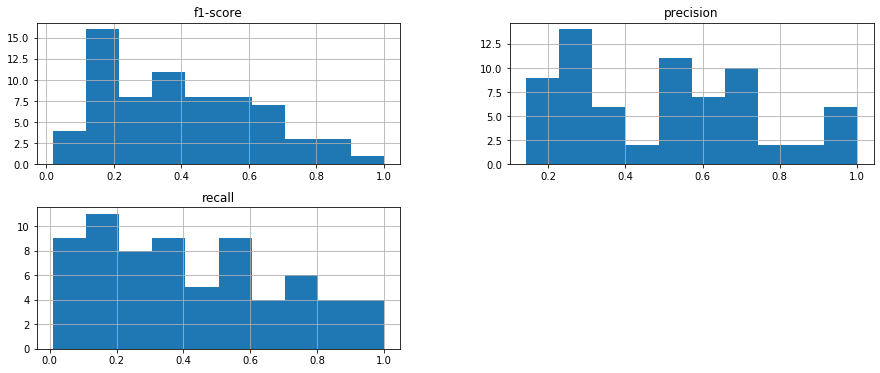

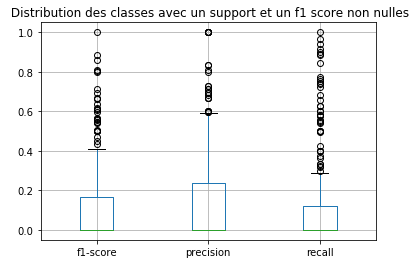

In [42]:
mlb = MultiLabelBinarizer()
h = mlb.fit_transform(multi_df[typo])
y = df[typo].values
f = lambda x : np.log(x+300)
#f = lambda x: x
val = 0.1
W = compute_weight(mlb,y,f)
model_w = train_typo(W) 
rapport =  evaluate_model (model_w,X_test,y_test, val)
make_repport(rapport)

##### Distribution
DescribeResult(nobs=273, minmax=(0.020382645620222968, 110.08389648957159), mean=18.32255577269645, variance=740.167108813518, skewness=2.262733117598544, kurtosis=4.598379853823493)
Epoch 1/5
659/659 [==============================] - 33s 50ms/step - loss: 0.0213 - categorical_accuracy: 0.0751 - val_loss: 0.0221 - val_categorical_accuracy: 0.0923
Epoch 2/5
659/659 [==============================] - 30s 46ms/step - loss: 0.0174 - categorical_accuracy: 0.1915 - val_loss: 0.0202 - val_categorical_accuracy: 0.3594
Epoch 3/5
659/659 [==============================] - 31s 46ms/step - loss: 0.0141 - categorical_accuracy: 0.3417 - val_loss: 0.0191 - val_categorical_accuracy: 0.3328
Epoch 4/5
659/659 [==============================] - 31s 48ms/step - loss: 0.0115 - categorical_accuracy: 0.3605 - val_loss: 0.0180 - val_categorical_accuracy: 0.3780
Epoch 5/5
659/659 [==============================] - 32s 48ms/step - loss: 0.0098 - categorical_accuracy: 0.3633 - val_loss: 0.017

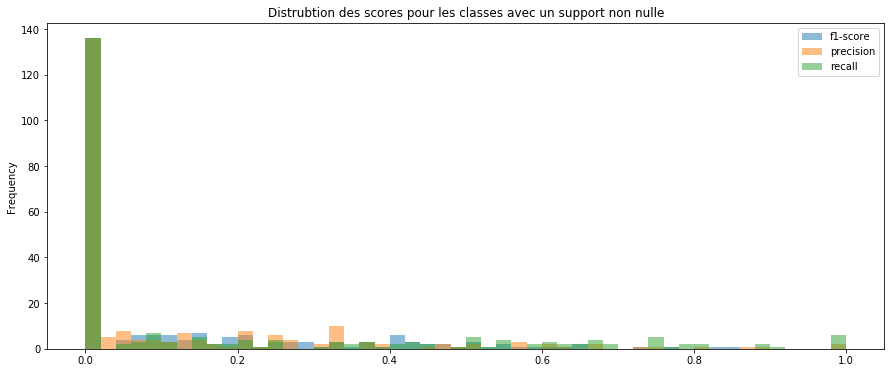

<Figure size 432x288 with 0 Axes>

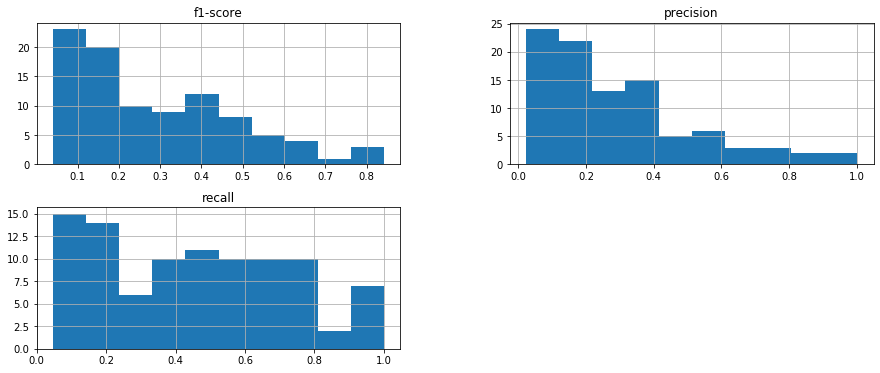

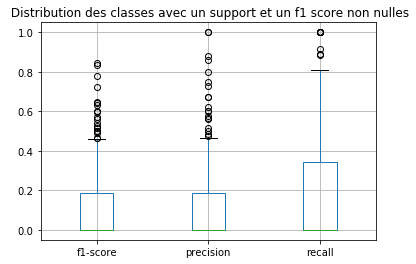

In [43]:
mlb = MultiLabelBinarizer()
h = mlb.fit_transform(multi_df[typo])
y = df[typo].values
f = lambda x : x**(1/1.2)
#f = lambda x: x
val = 0.1
W = compute_weight(mlb,y,f)
model_w = train_typo(W) 
rapport =  evaluate_model (model_w,X_test,y_test, val)
make_repport(rapport)

In [48]:
f = lambda x : x
def compute_weight(mlb,y,f):
    w = class_weight.compute_class_weight('balanced',np.unique(y),y)
    u = f(w)# np.exp(w.dot(1000)) / np.sum(np.exp(w.dot(1000)))
    class_weights = dict(zip(np.arange(0,len(mlb.classes_)),u))
    print('##### Distribution')
    print(stats.describe(u))

    return(class_weights)

In [60]:
from collections import Counter
Counter(y).values()

dict_values([30127, 805, 763, 370, 290, 658, 2253, 14, 299, 1756, 355, 3342, 2168, 949, 418, 1933, 1479, 545, 1764, 1043, 798, 271, 779, 660, 501, 588, 1757, 126, 2751, 236, 82, 63, 62, 359, 208, 32, 13, 462, 238, 467, 500, 100, 43, 221, 632, 128, 191, 10, 528, 239, 75, 64, 840, 49, 181, 34, 143, 61, 27, 46, 75, 77, 29, 268, 19, 106, 30, 47, 135, 110, 16, 600, 130, 18, 7, 1394, 24, 129, 254, 234, 400, 75, 21, 11, 4, 7, 182, 56, 16, 105, 112, 247, 84, 100, 67, 17, 187, 99, 38, 17, 145, 190, 76, 389, 230, 103, 58, 14, 19, 6, 30, 40, 28, 29, 17, 22, 192, 62, 3, 84, 43, 62, 17, 24, 42, 40, 35, 4, 22, 103, 39, 17, 8, 18, 121, 124, 1, 12, 110, 64, 31, 115, 73, 11, 8, 64, 16, 5, 274, 4, 91, 184, 19, 9, 5, 167, 42, 51, 5, 41, 6, 4, 41, 59, 15, 118, 22, 12, 2, 17, 36, 88, 1, 7, 7, 33, 2, 58, 30, 7, 44, 42, 10, 2, 10, 11, 13, 45, 22, 58, 7, 4, 7, 7, 5, 26, 7, 5, 2, 2, 16, 6, 6, 8, 6, 23, 4, 7, 35, 3, 11, 12, 1, 21, 12, 8, 4, 1, 1, 16, 1, 14, 1, 2, 1, 1, 29, 17, 3, 2, 3, 2, 1, 4, 6, 4, 18, 5, 19,

Epoch 1/5
659/659 [==============================] - 29s 43ms/step - loss: 0.0156 - categorical_accuracy: 0.0784 - val_loss: 0.0217 - val_categorical_accuracy: 0.1075
Epoch 2/5
659/659 [==============================] - 31s 47ms/step - loss: 0.0122 - categorical_accuracy: 0.1554 - val_loss: 0.0204 - val_categorical_accuracy: 0.1814
Epoch 3/5
659/659 [==============================] - 28s 43ms/step - loss: 0.0100 - categorical_accuracy: 0.1999 - val_loss: 0.0197 - val_categorical_accuracy: 0.1504
Epoch 4/5
659/659 [==============================] - 28s 43ms/step - loss: 0.0084 - categorical_accuracy: 0.2257 - val_loss: 0.0188 - val_categorical_accuracy: 0.1983
Epoch 5/5
659/659 [==============================] - 28s 43ms/step - loss: 0.0071 - categorical_accuracy: 0.2462 - val_loss: 0.0188 - val_categorical_accuracy: 0.1954
F1 sample :  0.20088225271105423
seui 0.1
    Precision: 0.2260, Recall: 0.2736, F1-measure: 0.2255
              precision    recall  f1-score   support

          

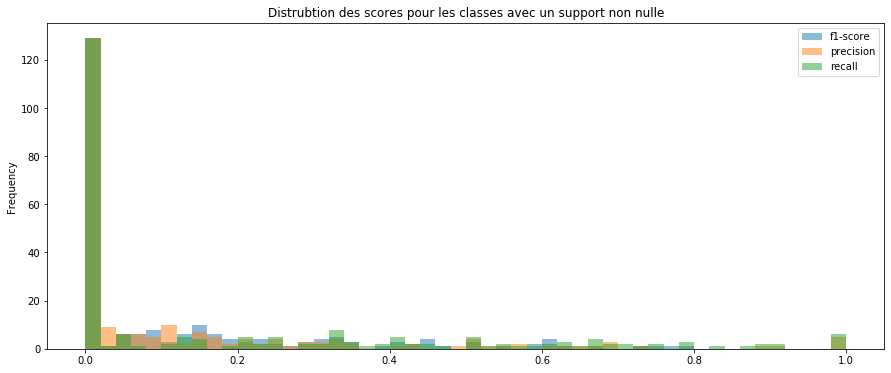

<Figure size 432x288 with 0 Axes>

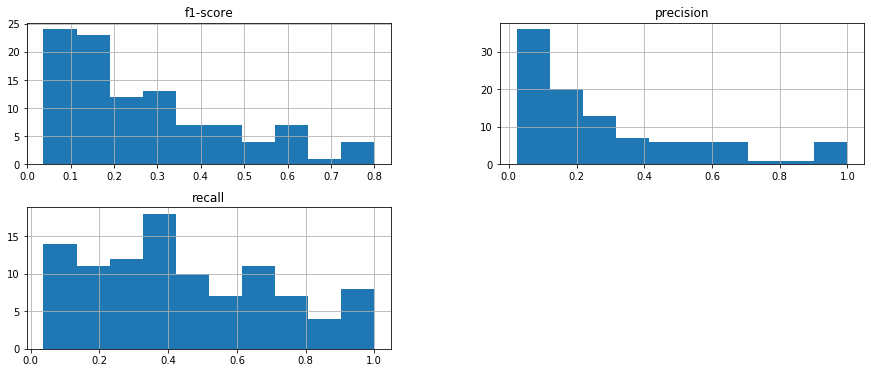

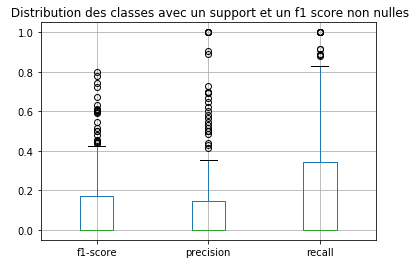

In [76]:
def seuil(x):
    if x < 10:
        return 10
    elif (x >=10) & (x <100):
        return 5 
    elif (x >=100) & (x <500):
        return 1
    elif (x >=500) & (x <1000):
        return 0.5
    elif (x >=1000) & (x <3000):
        return 0.1
    else : 
        return 0.1
    

poids = pd.Series(y).groupby(y).count().values
name = np.unique(y)
df_w = pd.DataFrame()
df_w['name']=name
df_w['poids']=poids
df_w['W'] = df_w['poids'].map(seuil)
W = dict(zip(np.arange(0,len(name)),df_w['W'].values))
model_w = train_typo(W) 
rapport =  evaluate_model (model_w,X_test,y_test, val)
make_repport(rapport)


In [71]:
len(np.unique(np.argmax(model_w.predict(X_test),axis=1)))

116

##### Distribution
DescribeResult(nobs=273, minmax=(0.09672891853959537, 16.789365201900395), mean=4.619160456119744, variance=17.859299256540698, skewness=1.4638052959797438, kurtosis=1.550694728833534)
Epoch 1/5
659/659 [==============================] - 40s 60ms/step - loss: 0.0150 - categorical_accuracy: 0.5654 - val_loss: 0.0161 - val_categorical_accuracy: 0.6160
Epoch 2/5
659/659 [==============================] - 39s 59ms/step - loss: 0.0118 - categorical_accuracy: 0.6044 - val_loss: 0.0140 - val_categorical_accuracy: 0.6272
Epoch 3/5
659/659 [==============================] - 38s 58ms/step - loss: 0.0102 - categorical_accuracy: 0.6072 - val_loss: 0.0135 - val_categorical_accuracy: 0.6046
Epoch 4/5
659/659 [==============================] - 35s 53ms/step - loss: 0.0090 - categorical_accuracy: 0.6016 - val_loss: 0.0132 - val_categorical_accuracy: 0.5744
Epoch 5/5
659/659 [==============================] - 37s 57ms/step - loss: 0.0081 - categorical_accuracy: 0.5982 - val_loss: 0.0

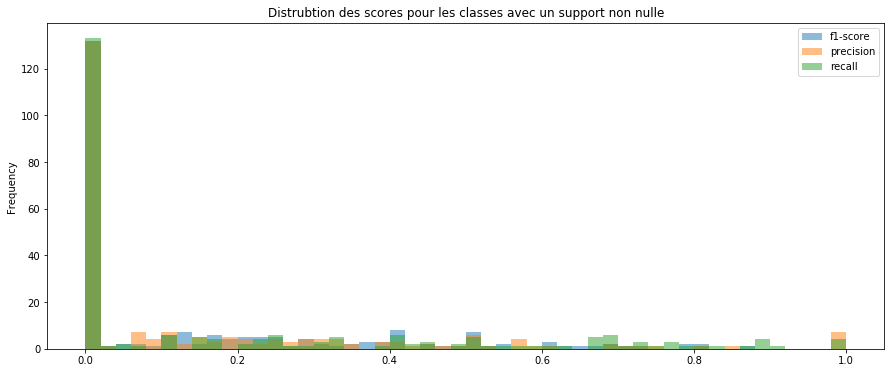

<Figure size 432x288 with 0 Axes>

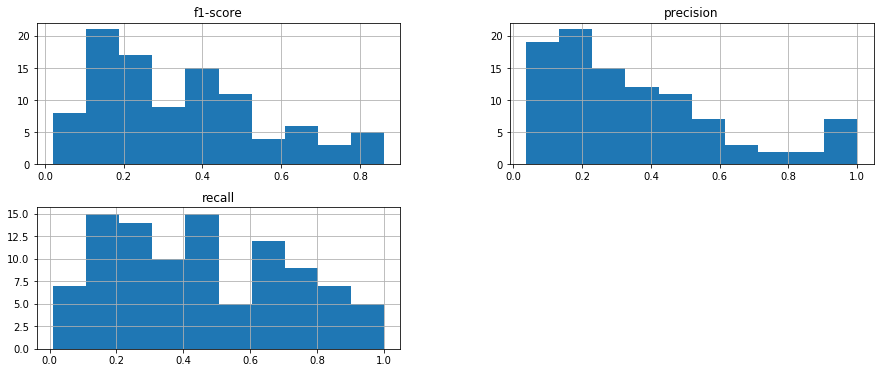

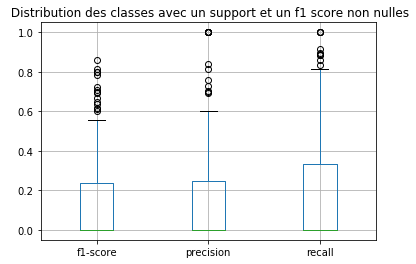

In [72]:
mlb = MultiLabelBinarizer()
h = mlb.fit_transform(multi_df[typo])
y = df[typo].values
f = lambda x : x**(1/2)
#f = lambda x: x
val = 0.1
W = compute_weight(mlb,y,f)
model_w = train_typo(W) 
rapport =  evaluate_model (model_w,X_test,y_test, val)
make_repport(rapport)


Epoch 1/5
659/659 [==============================] - 54s 82ms/step - loss: 0.0198 - categorical_accuracy: 0.5705 - val_loss: 0.0133 - val_categorical_accuracy: 0.6116
Epoch 2/5
659/659 [==============================] - 54s 82ms/step - loss: 0.0148 - categorical_accuracy: 0.6265 - val_loss: 0.0122 - val_categorical_accuracy: 0.6416
Epoch 3/5
659/659 [==============================] - 43s 65ms/step - loss: 0.0135 - categorical_accuracy: 0.6510 - val_loss: 0.0119 - val_categorical_accuracy: 0.6435
Epoch 4/5
659/659 [==============================] - 50s 76ms/step - loss: 0.0128 - categorical_accuracy: 0.6597 - val_loss: 0.0117 - val_categorical_accuracy: 0.6418
Epoch 5/5
659/659 [==============================] - 56s 84ms/step - loss: 0.0123 - categorical_accuracy: 0.6686 - val_loss: 0.0116 - val_categorical_accuracy: 0.6439
F1 sample :  0.6676377690886898
seui 0.1
    Precision: 0.6472, Recall: 0.7537, F1-measure: 0.6655
              precision    recall  f1-score   support

           

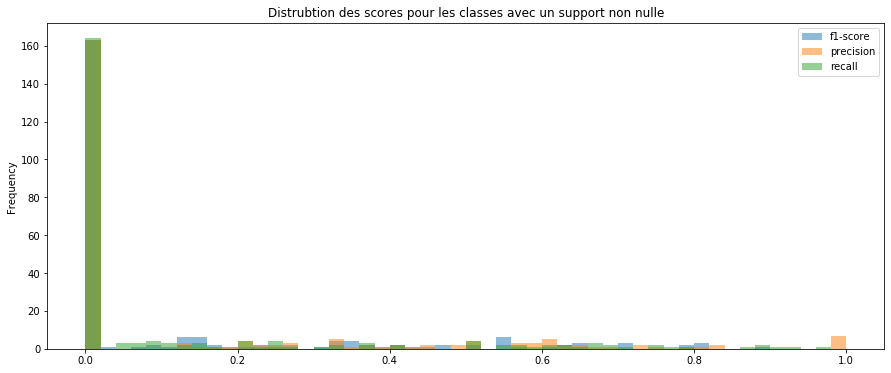

<Figure size 432x288 with 0 Axes>

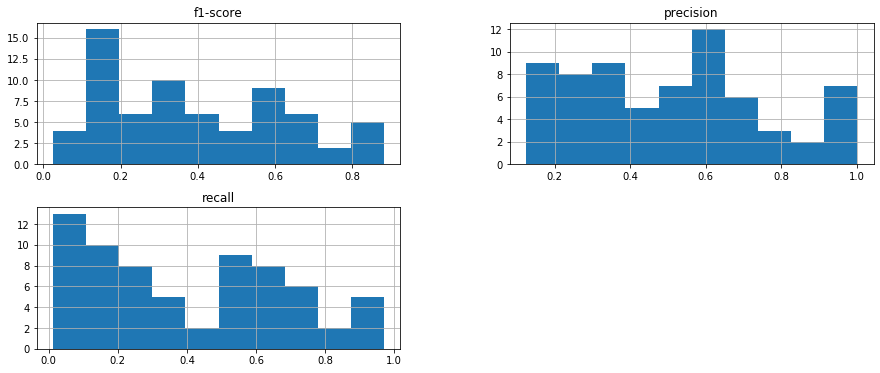

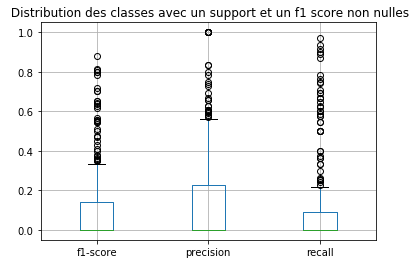

In [73]:
mlb = MultiLabelBinarizer()

val = 0.1

model_w = train_typo(None) 
rapport =  evaluate_model (model_w,X_test,y_test, val)
make_repport(rapport)